In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
import pandas as pd
import tensorflow as tf
import h5py
import os
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# Upload and read the csv files
ais_df = pd.read_csv("ml_data_daily_2018.csv", index_col=0)

In [2]:
# Look at our data
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
2018/01/01,9,37,145,44,27,13,12,7
2018/01/02,13,45,119,41,27,14,19,10
2018/01/03,13,44,106,40,36,14,20,11
2018/01/04,15,44,103,45,30,10,15,12
2018/01/05,10,45,107,41,26,13,21,10


In [3]:
# Creating a total column for our data
ais_df['Total']= ais_df.sum(axis=1)
ais_df.head()

,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable,Total
2018/01/01,9,37,145,44,27,13,12,7,294
2018/01/02,13,45,119,41,27,14,19,10,288
2018/01/03,13,44,106,40,36,14,20,11,284
2018/01/04,15,44,103,45,30,10,15,12,274
2018/01/05,10,45,107,41,26,13,21,10,273


In [4]:
# Check the info of the DataFrame to make sure we have clean data
ais_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2018/01/01 to 2018/12/31
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Fishing       365 non-null    int64
 1   TugTow        365 non-null    int64
 2   Recreational  365 non-null    int64
 3   Passenger     365 non-null    int64
 4   Cargo         365 non-null    int64
 5   Tanker        365 non-null    int64
 6   Other         365 non-null    int64
 7   Unavailable   365 non-null    int64
 8   Total         365 non-null    int64
dtypes: int64(9)
memory usage: 28.5+ KB


In [5]:
# Create nine DataFrames, each with the Index and one unique column:
# Fishing
ais_fishing_df = ais_df.drop(["TugTow","Recreational","Passenger","Cargo","Tanker","Other","Unavailable","Total"], axis=1)
# TugTow
ais_tugtow_df = ais_df.drop(["Fishing","Recreational","Passenger","Cargo","Tanker","Other","Unavailable","Total"], axis=1)
# Recreational
ais_recreational_df = ais_df.drop(["Fishing","TugTow","Passenger","Cargo","Tanker","Other","Unavailable","Total"], axis=1)
# Passenger
ais_passenger_df = ais_df.drop(["Fishing","TugTow","Recreational","Cargo","Tanker","Other","Unavailable","Total"], axis=1)
# Cargo
ais_cargo_df = ais_df.drop(["Fishing","TugTow","Recreational","Passenger","Tanker","Other","Unavailable","Total"], axis=1)
# Tanker
ais_tanker_df = ais_df.drop(["Fishing","TugTow","Recreational","Passenger","Cargo","Other","Unavailable","Total"], axis=1)
# Other
ais_other_df = ais_df.drop(["Fishing","TugTow","Recreational","Passenger","Cargo","Tanker","Unavailable","Total"], axis=1)
# Unavailable
ais_unavailable_df = ais_df.drop(["Fishing","TugTow","Recreational","Passenger","Cargo","Tanker","Other","Total"], axis=1)
# Total
ais_total_df = ais_df.drop(["Fishing","TugTow","Recreational","Passenger","Cargo","Tanker","Other","Unavailable"], axis=1)

In [ ]:
# Using Total as an example, create an SMA period over the course of 15, 30, and 60 days
# ais_total_df["15days"] = ais_total_df["Total"].rolling(15, min_periods=1).mean()
# ais_total_df["30days"] = ais_total_df["Total"].rolling(30, min_periods=1).mean()
# ais_total_df["60days"] = ais_total_df["Total"].rolling(60, min_periods=1).mean()
# ais_total_df["90days"] = ais_total_df["Total"].rolling(90, min_periods=1).mean()

In [6]:
# Check the new Dataframe
ais_total_df

,Total
2018/01/01,294
2018/01/02,288
2018/01/03,284
2018/01/04,274
2018/01/05,273
...,...
2018/12/27,298
2018/12/28,298
2018/12/29,306
2018/12/30,308


Text(0, 0.5, 'Number of Boats')

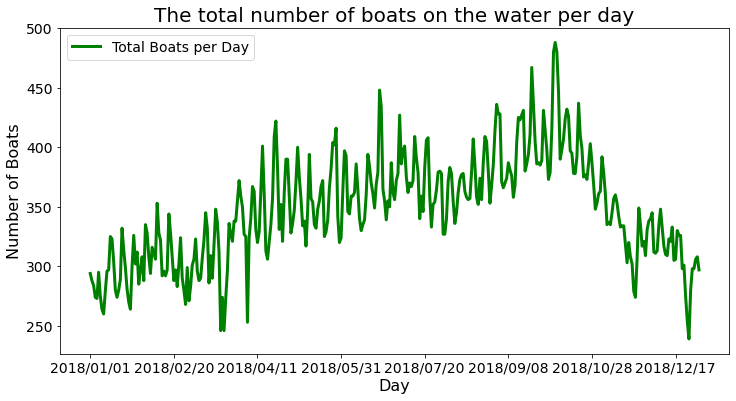

In [7]:
#Display the data
# Grean = Avg Air Temp, RED = 10 yrs, ORANG colors for the line plot
colors = ['green', 'red', 'orange', 'yellow', 'blue']
# Line plot 
ais_total_df.plot(color=colors, linewidth=3, figsize=(12,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Total Boats per Day', '15-day SMA', '30-day SMA', '60-day SMA', '90-day SMA'], fontsize=14)
plt.title('The total number of boats on the water per day', fontsize=20)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Number of Boats', fontsize=16)

In [38]:
# Build a function to split the Time Series into test and train data
def build_training_data(dataset, history_size = 30, target_size = 7):
    start_index = history_size
    end_index = len(dataset) - target_size
    
    data = []
    labels = []

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, 1)
        data.append(dataset[indices])
        labels.append(dataset[i:i + target_size])

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

dataset = ais_total_df.values
data, labels = build_training_data(dataset)

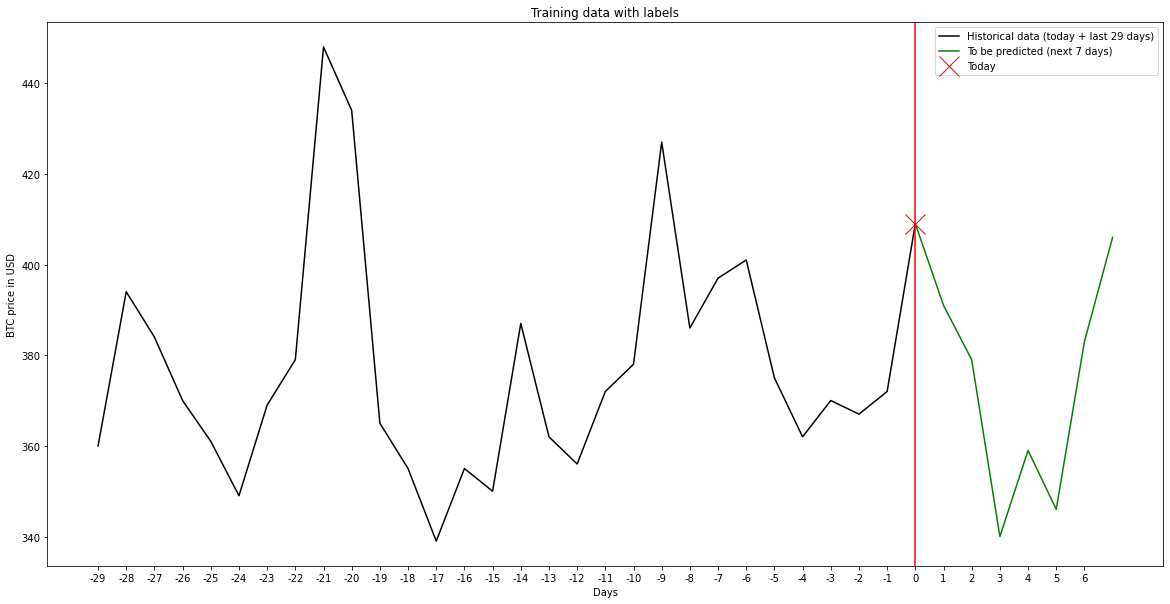

In [40]:
plt.rcParams["figure.figsize"] = (20,10)

day = 165
plt.plot(range(0, 30), data[day], 'k-', label = 'Historical data (today + last 29 days)')
plt.plot(range(29, 37), np.concatenate([data[day][29:], labels[day]]), 'g-', label = 'To be predicted (next 7 days)')
plt.axvline(x=29, c = 'r')
plt.plot(29, data[day][29], 'rx', markersize = 20, label = "Today")
plt.xticks(range(0, 36), range(-29, 7))
plt.title('Training data with labels')
plt.xlabel('Days')
plt.ylabel('BTC price in USD')
plt.legend()
plt.show()

In [ ]:
# Split the total Dataframe into X and y values
ais_total_df_y = ais_total_df.drop(["15days","30days","60days","90days"],axis=1)
ais_total_df_X = ais_total_df.drop(["Total"],axis=1)

In [ ]:
# Split our preprocessed data into our features and target arrays
y = ais_total_df_y
X = ais_total_df_X

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [ ]:
# Create a MinMaxScaler instances
scaler = MinMaxScaler()

# Fit the MinMaxScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Add a dimension to our features
n_features=1
X_3D = X.values.reshape((X.shape[0], X.shape[1], n_features))
# Check the shape of the new data
X_3D.shape

In [ ]:
# Define the RNN Model

model = Sequential()
input_features = X_3D.shape[1]

# Recurrent layer
model.add(LSTM(1460, activation='relu', input_shape=(X_3D.shape[1], X_3D.shape[2]), return_sequences=False, dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(units=64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1, activation='softmax'))

In [ ]:
# Check the structure of the model
model.summary()

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [ ]:
# Creating callbacks to load the model for a future time
cp_callback = [EarlyStopping(monitor='val_loss', patience=5), ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, save_weights_only=False)]

In [ ]:
# Train the model
fit_model = model.fit(X_train_scaled,y_train,epochs=20,callbacks=cp_callback)

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")